# Part 1: 
In your project you have been working with a bias dataset. Most probabely suupervised models were underfit. You should remember that this is a real dataset, and in real life most of the time you dont have access to clean and unbias dataset. In situations like this, none of the regression models will have a good fit for the dataset due to the large predence of the 0s. In the first part of this take-home exam, you are asked to be creative, and find a solution for this problem. 

For this dataset, you can break the problem, into a two-step machine learning model. 

First step is to classify the data points as positive revenue and zero revenue. This simply is a binary classification. You should remember that when you are dealing with biased datasets, accuracy is not a reliable scoring metric. So look for a robust scoring function. 

Next, you need to build a regression model to postprocess classification results. Here is a flow chart to show you the outline of the model. 

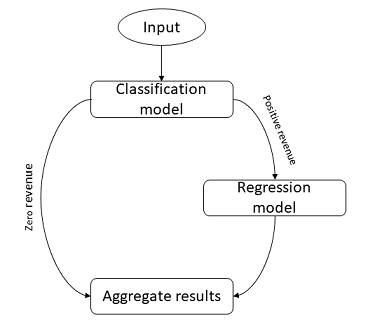

In [1]:
## importing libraries
import pandas as pd
import numpy as np
import os
import sklearn as sk
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import simplejson as json
plt.style.use('dark_background')
import datetime
import time
from sklearn.linear_model import LogisticRegression
## Easing the limits on the number of output columns and rows shown because the dataset is massive 
## and we will sometimes need to take a closer look at the data structure.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

In [2]:
from sklearn.metrics import mean_squared_error, make_scorer, confusion_matrix, accuracy_score, precision_score, roc_auc_score
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV, validation_curve, train_test_split, GridSearchCV
from scipy.spatial.distance import cdist
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FastICA
from sklearn.linear_model import LogisticRegression

def rmse(y, y_pred):
    return np.sqrt(np.mean((y_pred - y)**2))

In [3]:
## defining the functions that will extract the values out of json-like columns

def todict(dic, key, value):
    if key in dic:
        dic[key].append(value)
    else:
        dic[key] = [value]
    return dic

def resolve_json(hitsdic, hits_json, key='NoneName'):
    if type(hits_json) == list:
        if len(hits_json) == 0:
            pass
        else:
            for subjson in hits_json:
                hitsdic = resolve_json(hitsdic, subjson)
    elif type(hits_json) == dict:
        for i in hits_json.keys():
            hitsdic = resolve_json(hitsdic, hits_json[i],i)
    else:
        hitsdic = todict(hitsdic, key, hits_json)
    return hitsdic

def complex_replace(x):
    dic = {}
    return resolve_json(dic, json.loads(x.replace('\'','\"'). \
                                        replace('TRUE','true'). \
                                        replace('True','true'). \
                                        replace('FALSE','false'). \
                                        replace('False','false'). \
                                        replace(', \"',', !&~'). \
                                        replace('\", ','!&~, '). \
                                        replace('\": ','!&~: '). \
                                        replace(': \"',': !&~'). \
                                        replace(' {\"',' {!&~'). \
                                        replace('\"}, ','!&~}, '). \
                                        replace('[{\"','[{!&~'). \
                                        replace('\"}]','!&~}]'). \
                                        replace('\"','_'). \
                                        replace('!&~','\"'). \
                                        encode('gbk','ignore'). \
                                        decode('utf-8','ignore'). \
                                        replace('\\','')))


def replace(x):
    return  json.loads(x.replace('\'','\"').replace('False', 'false').replace('True','true'))


In [4]:
data = pd.read_csv('data.csv',dtype={'fullVisitorId': 'str'})
traf_cols = pd.DataFrame(json_normalize(data['trafficSource'].apply(eval))[["medium","source"]])
geo_cols = pd.DataFrame(pd.io.json.json_normalize(data["geoNetwork"].apply(eval))[["country","continent"]])
dev_cols = pd.DataFrame(pd.io.json.json_normalize(data["device"].apply(eval))[["browser","deviceCategory","operatingSystem"]])

In [5]:
df = pd.DataFrame(pd.concat([data.drop(["trafficSource","geoNetwork","device","hits","customDimensions"],axis=1),dev_cols,traf_cols,geo_cols],axis=1,sort=False))
df['date2'] = df['date'].apply(lambda x: datetime.datetime.strptime(str(x), "%Y%m%d"))
df = df.drop(["socialEngagementType","totals_totalTransactionRevenue"], axis = 1)
df['totals_transactionRevenue'].fillna(0,inplace=True)
df['totals_transactions'].fillna(0,inplace=True)
df['totals_bounces'].fillna(0,inplace=True)
df['totals_newVisits'].fillna(0,inplace=True)
df['totals_timeOnSite'].fillna(0,inplace=True)
df['totals_pageviews'].fillna(0,inplace=True)

In [6]:
## defining the new target variable for the first part of our model.
df["totals_transactionRevenue_positive"] = df['totals_transactionRevenue'].apply(lambda x: 1 if x>0 else 0)

In [7]:
df2 = df.drop(["date","fullVisitorId","visitId","visitStartTime","date2","totals_sessionQualityDim", "totals_transactions"],axis=1)

In [8]:
#, "totals_transactions"

In [9]:
X = df2.drop(["totals_transactionRevenue_positive"], axis=1)
y = df2["totals_transactionRevenue_positive"]

In [10]:
obj_cols = X.select_dtypes(include=['object'])
for col in obj_cols:
    X[col] = X[col].astype('category')
X = pd.get_dummies(X,drop_first = True)

In [11]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

In [12]:
Xtrain2 = Xtrain.drop(["totals_transactionRevenue"], axis = 1)
Xtest2 = Xtest.drop(["totals_transactionRevenue"], axis = 1)

In [13]:
num_cols = ['visitNumber', 'totals_bounces', 'totals_hits', 'totals_newVisits', 'totals_pageviews', 'totals_timeOnSite','totals_visits']
scaler = preprocessing.StandardScaler().fit(Xtrain[num_cols])
Xtrain[num_cols] = scaler.transform(Xtrain[num_cols])
Xtest[num_cols] = scaler.transform(Xtest[num_cols])

D:\Downloads\software\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Downloads\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Downloads\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Downloads\software\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: S

##### simple logistic regression, we can see that almost everything is predicted as a 0.

In [14]:
#lr = LogisticRegression(solver="liblinear").fit(Xtrain,ytrain)
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
grid_lr = GridSearchCV(LogisticRegression(solver="liblinear", max_iter = 500), grid, cv = 5)
grid_lr.fit(Xtrain2,ytrain)

print("tuned hpyerparameters :(best parameters) ",grid_lr.best_params_)
print("accuracy :",grid_lr.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.001, 'penalty': 'l2'}
accuracy : 0.9904666666666667


In [15]:
confusion_matrix(ytrain, grid_lr.predict(Xtrain2))

array([[14854,     2],
       [  142,     2]], dtype=int64)

In [16]:
confusion_matrix(ytest, grid_lr.predict(Xtest2))

array([[4951,    0],
       [  49,    0]], dtype=int64)

##### We need to use a different scorer. lets try area under the ROC curve first

In [17]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
grid_lr_roc = GridSearchCV(LogisticRegression(solver="liblinear",max_iter = 500), grid ,scoring = "roc_auc", cv = 5)
grid_lr_roc.fit(Xtrain2,ytrain)

print("tuned hpyerparameters :(best parameters) ",grid_lr_roc.best_params_)
print("ROC :",grid_lr_roc.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l1'}
ROC : 0.976747054626986


##### We can see that we only managed to predict just a few positive class rows correctly

In [18]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
grid_lr_prec = GridSearchCV(LogisticRegression(solver="liblinear",max_iter = 250), grid ,scoring = "precision", cv = 5).fit(Xtrain2,ytrain)

print("tuned hpyerparameters :(best parameters) ",grid_lr_prec.best_params_)
print("precision :",grid_lr_prec.best_score_)

D:\Downloads\software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Downloads\software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Downloads\software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Downloads\software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Downloads\software\Anaconda3\lib\site-packages\sklear

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l1'}
precision : 0.4909121212121212


In [19]:
confusion_matrix(ytest, grid_lr_roc.predict(Xtest2))

array([[4946,    5],
       [  48,    1]], dtype=int64)

In [20]:
confusion_matrix(ytest, grid_lr_prec.predict(Xtest2))

array([[4946,    5],
       [  46,    3]], dtype=int64)

##### Making the model maximize precision didnt help that much over maximizing AUC. Thats a bummer 

In [21]:
confusion_matrix(ytest, grid_lr_prec.predict(Xtest2))

array([[4946,    5],
       [  46,    3]], dtype=int64)

In [22]:
lr_prec_acc = accuracy_score(ytest,grid_lr_prec.predict(Xtest2))
lr_prec_acc

0.9898

##### Trying a boosting algorithm to see if it can improve our model. Boosting weighs the hard-to-classify rows more than others so perhaps it can classify the positive class more accurately

In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [24]:
param_grid = {"n_estimators": [50,250,300,350,500],
              "learning_rate": [0.001,0.01,0.1,1,2]}
# run grid search
DTC = DecisionTreeClassifier(random_state = 1, max_depth = 296)
bdt = AdaBoostClassifier(base_estimator = DTC)
#grid_boost = bdt.fit(Xtrain,ytrain)
grid_boost = GridSearchCV(bdt, param_grid=param_grid, scoring = 'precision', cv=5, refit=True).fit(Xtrain2,ytrain)

##### well, not the best precision out of all the models. True positive increased but false positives and false negatives also increased

In [25]:
confusion_matrix(ytest, grid_boost.predict(Xtest2))

array([[4912,   39],
       [  37,   12]], dtype=int64)

In [26]:
print("Precision: ", grid_boost.best_score_)

Precision:  0.28621743867770433


##### Attempting one last thing. Clustering helped in the project a little bit. lets see if it can improve the results here

In [27]:
kmeans = KMeans(n_clusters=6).fit(Xtrain2) 
Xtrain2["cluster"] = kmeans.predict(Xtrain2)
Xtest2["cluster"] = kmeans.predict(Xtest2)
#t7 = pd.DataFrame(kmeans.predict(Xtest),ytest)

##### training the model with a grid search using precision as the metric and logistic regression as the algorithm with clustering results as a variable

In [28]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
grid_lr_prec_kmeans = GridSearchCV(LogisticRegression(solver="liblinear",max_iter = 250), grid ,scoring = "precision", cv = 5).fit(Xtrain2,ytrain)

D:\Downloads\software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Downloads\software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Downloads\software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Downloads\software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Downloads\software\Anaconda3\lib\site-packages\sklear

##### That didnt help precision too much either

In [29]:
print("tuned hpyerparameters :(best parameters) ",grid_lr_prec_kmeans.best_params_)
print("precision :",grid_lr_prec_kmeans.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2'}
precision : 0.4809121212121212


##### adding a variable which is our model's prediction of whether a row has revenue or not

In [30]:
Xtrain2["revenue_pred"] = grid_lr_prec_kmeans.predict(Xtrain2)
Xtest2["revenue_pred"] = grid_lr_prec_kmeans.predict(Xtest2)

##### Getting back our second dependent variable, which was the actual dollar amount of the revenue

In [31]:
ytrain_b = Xtrain["totals_transactionRevenue"]
ytest_b = Xtest["totals_transactionRevenue"]

##### Dividing the dataset so that we will only be running regression on the model where our previous prediction was for revenue to be non zero

In [32]:
Xtrain3 = Xtrain2[Xtrain2["revenue_pred"]==1]
ytrain3 = ytrain[Xtrain2["revenue_pred"]==1]
ytrain3b = ytrain_b[Xtrain2["revenue_pred"]==1]
Xtest3 = Xtest2[Xtest2["revenue_pred"]==1]
ytest3 = ytest[Xtest2["revenue_pred"]==1]
ytest3b = ytest_b[Xtest2["revenue_pred"]==1]

Xtrain4 = Xtrain2[Xtrain2["revenue_pred"]==0]
ytrain4b = ytrain_b[Xtrain2["revenue_pred"]==0]
Xtest4 = Xtest2[Xtest2["revenue_pred"]==0]
ytest4b = ytrain_b[Xtrain2["revenue_pred"]==0]

##### Regression model for prediction of how much revenue is in each row

In [33]:
alphas = np.array([2,1,0.1,0.01,0.001,0.0001]) # alpha parameters to test in grid search
# Grid Search for Algorithm Tuning
grid_ridge = GridSearchCV(cv = 5, estimator = Ridge(), scoring = make_scorer(rmse, greater_is_better = False), param_grid = dict(alpha = alphas)).fit(Xtrain3, ytrain3b)
print("training RMSE: ", rmse(ytrain3b, grid_ridge.predict(Xtrain3)))
print("testing RMSE:  ", rmse(ytest3b, grid_ridge.predict(Xtest3)))
print("Best alpha parameter: ", grid_ridge.best_estimator_.alpha)

training RMSE:  123922298.46939747
testing RMSE:   365788676.4193102
Best alpha parameter:  2.0


D:\Downloads\software\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


##### making prediction of how much revenue is for each row

In [34]:
Xtest3["revenue_pred2"] = grid_ridge.predict(Xtest3)
Xtrain3["revenue_pred2"] = grid_ridge.predict(Xtrain3)

D:\Downloads\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
D:\Downloads\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


##### putting revenue to be zero in rows where our classification model indicated zero-revenue instances

In [35]:
Xtrain4["revenue_pred2"] = 0
Xtest4["revenue_pred2"] = 0

D:\Downloads\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
D:\Downloads\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


##### Aggregating back the datasets to get one final RMSE value

In [36]:
Xtrain5 = Xtrain4.append(Xtrain3)
Xtest5 = Xtest4.append(Xtest3)
ytrain5b = ytrain4b.append(ytrain3b)
ytest5b = ytest4b.append(ytest3b)

##### building a small df to store rmse values. rmse for models in the project copied as is

In [37]:
acc = pd.DataFrame()
acc['model'] = ["Ridge Regression","Logistic + Ridge"]
acc['TrainRMSE'] = [ 16930090.156, rmse(Xtrain5["revenue_pred2"],ytrain5b)  ]
acc['TestRMSE'] = [  15204106.573, rmse(Xtest5["revenue_pred2"],ytest5b) ]
acc

,model,TrainRMSE,TestRMSE
0,Ridge Regression,16930090.156,15204106.573
1,Logistic + Ridge,19158347.173,365788676.419


##### We can see that test RMSE has gone really bad after this 2 stage model. The reason is the bad predictive power of the logistic model itself. Because it classifies almost all of the non-zero revenue rows as zero-revenue, the rmse shoots up dramatically

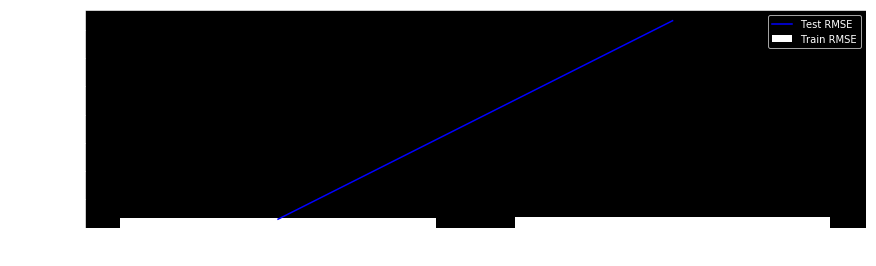

In [38]:
fig, ax = plt.subplots(1,1, figsize=(14,4))
ax.ticklabel_format(style="plain", useOffset=False)
ax.bar(acc.model,acc.TrainRMSE, color = 'white', label = "Train RMSE")
ax.plot(acc.model, acc.TestRMSE, color='blue', label='Test RMSE')
plt.legend(loc='best')
plt.xlabel('Models')
plt.ylabel('RMSE');

# Part 2
In this part you will create a Python function ``plot_decision_boundary`` that will accepts a machine learning model, feature set ``X``, and target set ``y`` as input and will plot the decision boundary of the input machine learning model  on ``(X,y)``. The following is a sample run of this function: 

In [39]:
def plot_decision_boundary(X, y, clf):
    reduced_data = X[:, :2]
    model = clf
    model.fit(reduced_data, y)
    markers = ["o" , "^" , "x" , "v" , "^" , "<", ">"]
    colors = ["black","darkred","#FF2D00"]
    marks = []
    for i in range(0,len(y)):
        marks.append(markers[y[i]])
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .01     # point in the mesh [x_min, m_max]x[y_min, y_max].    

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh using the model.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])    

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
#    sns.scatterplot(X[:, 0], X[:, 1], markers=["o", "x", "1"], hue = y)
    plt.figure(figsize= (8,8))
    plt.contourf(xx, yy, Z, alpha=0.25);
    plt.xlabel('sepal length [cm]')
    plt.ylabel('petal length [cm]')
    plt.title('Decicion boundary of chosen ML model on Iris dataset')
    
    for i in range(0,len(np.unique(y))):
        plt.scatter(X[y==i][:, 0], X[y==i][:, 1], c=colors[i], alpha=1, marker=markers[i])
    plt.legend(loc="best")
    return plt

D:\Downloads\software\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Downloads\software\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Downloads\software\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Downloads\software\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
No handles with labels found to put in legend.


<module 'matplotlib.pyplot' from 'D:\\Downloads\\software\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

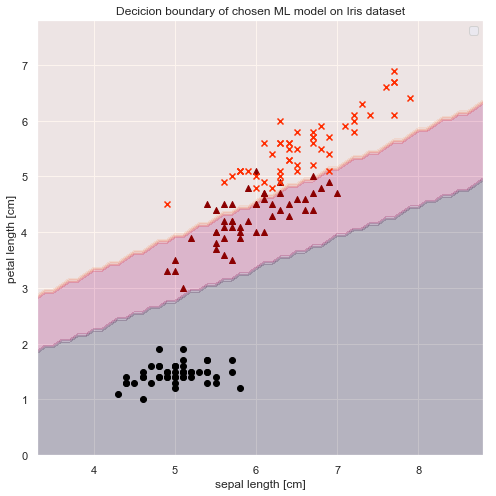

In [40]:
from sklearn import datasets
from sklearn.svm import SVC
import seaborn as sns
sns.set()

iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target

# Training a classifier
svm = SVC(kernel='rbf')
svm = LogisticRegression() #### <<< Comment out this line if you want to see radial kernel svm classifier
svm.fit(X, y)

# not sure why legend is not working
plot_decision_boundary(X, y, clf=svm)